# Background removal with SVD

## Import necessary packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from moviepy import VideoFileClip # for reading video
# may need "from moviepy.editor import VideoFileClip" for earlier version of moviepy

## Adjust print() precisions
`suppress = True` means suppressing scientific notation.

In [2]:
np.set_printoptions(precision = 2, suppress = True)

## Useful matrix operations with numpy
- `A.T`: transpose of `A`
- `@`: matrix multiplication

## SVD

In [3]:
A = np.array([[-1,-3,-3,-1],
              [2.5,1.5,1.5,2.5],
              [-2,0,0,-2]])
A

array([[-1. , -3. , -3. , -1. ],
       [ 2.5,  1.5,  1.5,  2.5],
       [-2. ,  0. ,  0. , -2. ]])

Take the SVD of A. In Python, `np.linalg.svd` outputs U, S, and **V transpose**.

In [4]:
U, S, Vt = np.linalg.svd(A)

In [5]:
U

array([[ 0.67, -0.67,  0.33],
       [-0.67, -0.33,  0.67],
       [ 0.33,  0.67,  0.67]])

S stores the singular values of A, and `len(S)` is the smaller of the two dimensions of A.

In [6]:
S

array([6., 3., 0.])

In [7]:
V = Vt.T
V

array([[-0.5 , -0.5 ,  0.33, -0.63],
       [-0.5 ,  0.5 , -0.63, -0.33],
       [-0.5 ,  0.5 ,  0.63,  0.33],
       [-0.5 , -0.5 , -0.33,  0.63]])

### check that both U and V are orthogonal matrices

In [8]:
print(U.T@U)
print(V.T@V)

[[ 1. -0.  0.]
 [-0.  1.  0.]
 [ 0.  0.  1.]]
[[ 1. -0. -0.  0.]
 [-0.  1.  0. -0.]
 [-0.  0.  1. -0.]
 [ 0. -0. -0.  1.]]


### Check that $A = U\Sigma V^T$

In [9]:
Sigma = np.zeros([3,4])
Sigma[:3,:3] = np.diag(S)
Sigma

array([[6., 0., 0., 0.],
       [0., 3., 0., 0.],
       [0., 0., 0., 0.]])

In [10]:
np.abs(A - U@Sigma@V.T)

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

## Read a video

In [36]:
video = VideoFileClip("../data/vid_background.avi")

In [37]:
video.fps, video.n_frames, video.w, video.h

(7.0, 794, 320, 240)

## See the first frame of this video
This is a colored image.

A colored image has 3 channels, so this is a $240 \times 320 \times 3$ array.

In [41]:
video.get_frame(0).shape

(240, 320, 3)

Show this first frame

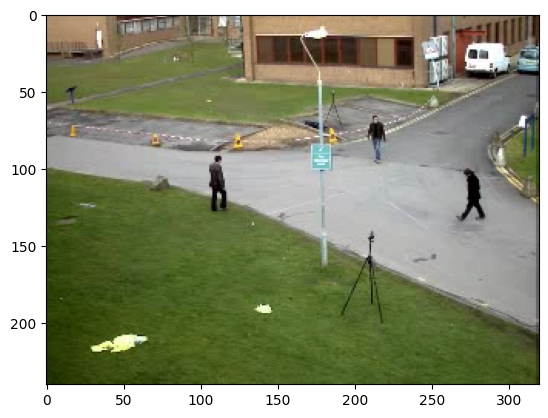

In [40]:
plt.imshow(video.get_frame(0));

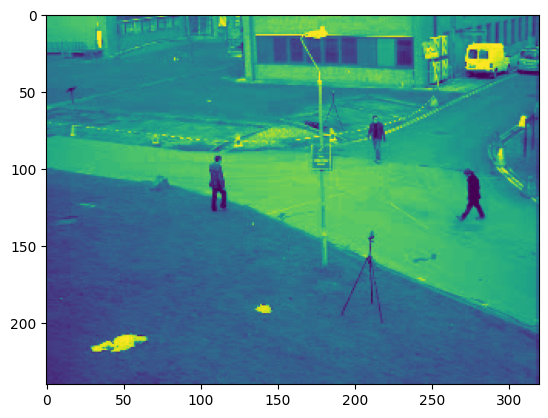

In [43]:
# showing the r channel
plt.imshow(video.get_frame(0)[:,:,0]);

we can turn this colored image to a grayscale one by averaging all 3 channels

In [44]:
vid_0_gray = video.get_frame(0)[:,:,0]/3 + video.get_frame(0)[:,:,1]/3 + video.get_frame(0)[:,:,2]/3

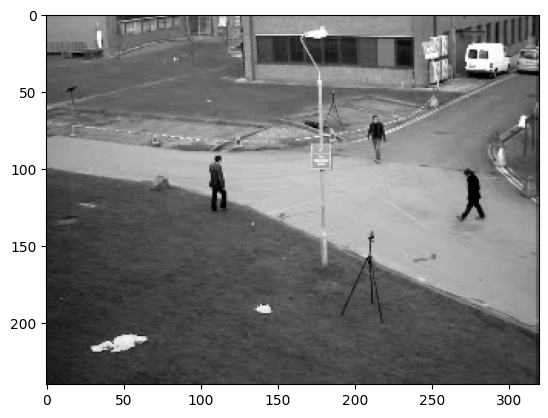

In [47]:
plt.imshow(vid_0_gray, cmap='gray');

In [48]:
vid=video.subclipped(0,50)

In [53]:
def rgb2gray(rgb):
    '''turn a colored video into a gray scale video
    m by n by 3 -> m by n
    '''
    return np.dot(rgb[...,:3], [1/3, 1/3, 1/3])

In [50]:
def create_data_matrix_from_video(clip, fps=6):
    return np.vstack([rgb2gray(clip.get_frame(i/float(fps))).flatten() for i in range(fps * int(clip.duration))]).T

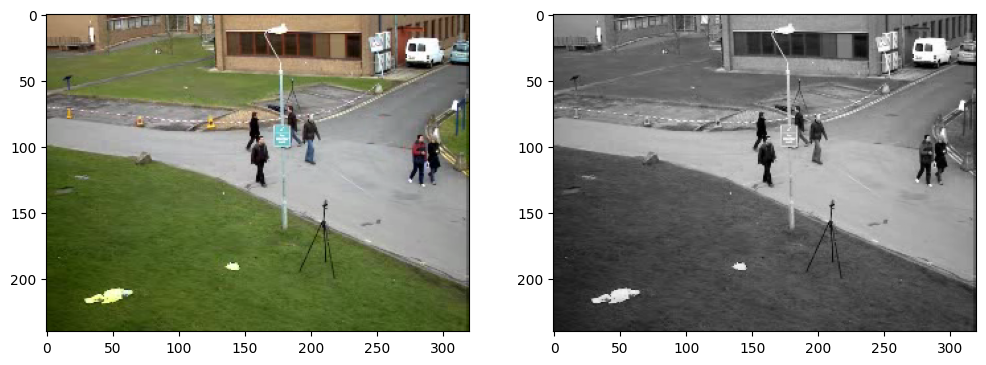

In [52]:
frame_idx = 50;
fig, axs1 = plt.subplots(1, 2, figsize=(12,12)) 
axs1[0].imshow(video.get_frame(frame_idx));
axs1[1].imshow(rgb2gray(video.get_frame(frame_idx)), cmap='gray');

## Vectorization of a matrix
This is to turn any matrix into one column vector. Usually it will be vectorized along the columns, as indicated below

$\begin{bmatrix}a&b&c\\x&y&z\\d&e&f\end{bmatrix}\longrightarrow\begin{bmatrix}a\\x\\d\\b\\y\\e\\c\\z\\f\end{bmatrix}$

In [56]:
video.get_frame(0).shape

(240, 320, 3)

In [58]:
rgb2gray(video.get_frame(0)).shape

(240, 320)

In [60]:
rgb2gray(video.get_frame(0)).flatten().shape

(76800,)

# Turn the video into ONE matrix

## 1. first make the colored video into a grayscale video, followed by vectorization

In [54]:
video.n_frames, video.w, video.h

(794, 320, 240)

In [61]:
M = create_data_matrix_from_video(vid, fps=7)

In [62]:
M.shape

(76800, 350)

The M matrix stores the WHOLE grayscale video, where the ith column of M is the ith frame of the video vectorized.

In [63]:
U, S, V = np.linalg.svd(M, full_matrices=False) 

In [64]:
U.shape

(76800, 350)

In [65]:
S

array([627573.74,  19847.2 ,  16831.31,  15639.76,  13616.08,  13415.44,
        13187.56,  12588.66,  12406.42,  11559.61,  11331.11,  11206.35,
        10450.16,  10331.89,  10232.44,  10074.59,   9760.55,   9624.05,
         9392.74,   9076.56,   8842.29,   8758.15,   8658.15,   8359.86,
         8140.55,   7951.45,   7939.72,   7669.79,   7543.21,   7389.06,
         7334.36,   7296.29,   7123.41,   6981.53,   6913.02,   6764.46,
         6717.1 ,   6625.2 ,   6329.  ,   6292.23,   6215.58,   6084.44,
         5902.21,   5836.22,   5807.68,   5711.93,   5613.94,   5553.71,
         5430.25,   5382.71,   5327.72,   5296.24,   5193.64,   5061.86,
         5012.67,   4974.88,   4872.74,   4811.01,   4778.49,   4763.62,
         4664.45,   4649.45,   4565.23,   4498.59,   4447.69,   4345.34,
         4308.98,   4251.65,   4240.75,   4165.12,   4100.41,   4019.42,
         3993.55,   3955.67,   3919.93,   3909.38,   3849.64,   3768.58,
         3737.35,   3692.65,   3652.05,   3638.82, 

# TBD